In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive






# Import Libraries

In [0]:
import gc
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.activations import elu, softmax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


# Hypermeter and Variable

In [0]:
kaggleDir = '/content/drive/Shared drives/Tensors/DL/'
train_img_dir = 'train/'
test_img_dir = 'test/'
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": " talking to passenger"}
IMG_DIM = 299
CHANNEL_SIZE = 3
SEED_VAL = 41
BATCH_SIZE = 50
EPOCHS = 2  # Tootal Number of epoch


In [0]:
img_rows = 224
img_cols = 224

# Data Augmentation
Data Augmentation is the technique to generate new sample from the existing sample. So, you can reduce generalization error. It will genrerate natrual sample. There are number of features, which can help you in data agumentation.

rotation_range : is a value in degrees (0-180), a range within which to randomly rotate pictures.

height_shift_range : Constructor control the amount of horizontal and vertical shift respectively.

width_shift_range : Constructor control the amount of horizontal and vertical shift respectively.

shear_range : Shear Intensity (Shear angle in counter-clockwise direction in degrees)

zoom_range : Range for random zoom

horizontal_flip : Randomly filp of input image in horizontally. But we can't use in our case. It can chane the class of images.

fill_mode : Points outside the boundaries of the input image are filled according to the given mode. (default Nearest)

# Import the Datasets

In [0]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

In [0]:
dataset = pd.read_csv(kaggleDir + 'driver_imgs_list.csv', low_memory=True)
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [0]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [0]:
from os.path import join
from glob import glob
 

In [0]:
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content/drive/Shared drives/Tensors/DL/drivers/train', 'c' + str(classed), '*.jpg'))
        print('Getting jpg')
        for file in files:
            
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=40)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('/content/drive/Shared drives/Tensors/DL/drivers/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [0]:
img_rows = 64
img_cols = 64
color_type = 1

In [0]:
#!pip install scikit-learn==0.19.1

In [0]:
nx_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', nx_train.shape)
print(nx_train.shape[0], 'train samples')

Train shape: (14400, 64, 64, 1)
14400 train samples


In [0]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  5%|▌         | 200/3922 [00:56<16:09,  3.84it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


# Dataset Visualization

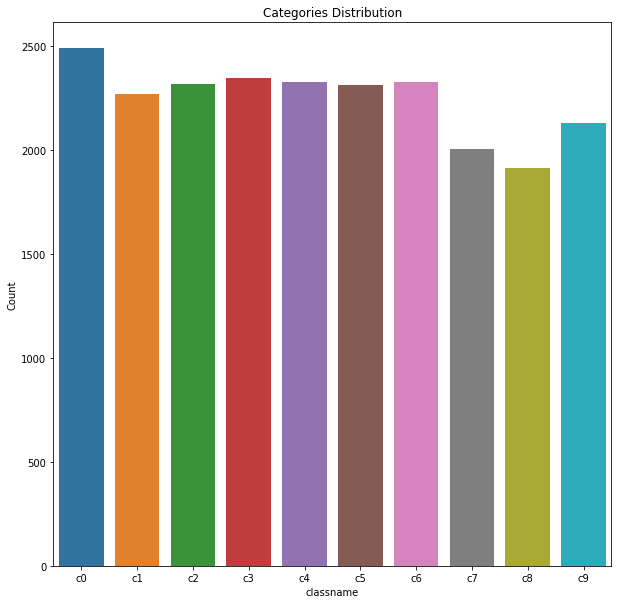

In [0]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [0]:
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

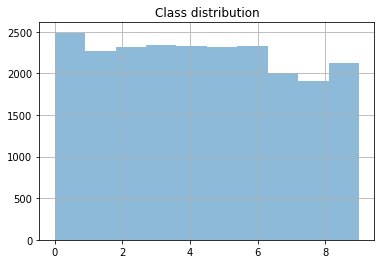

In [0]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

# Images overview

In [0]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

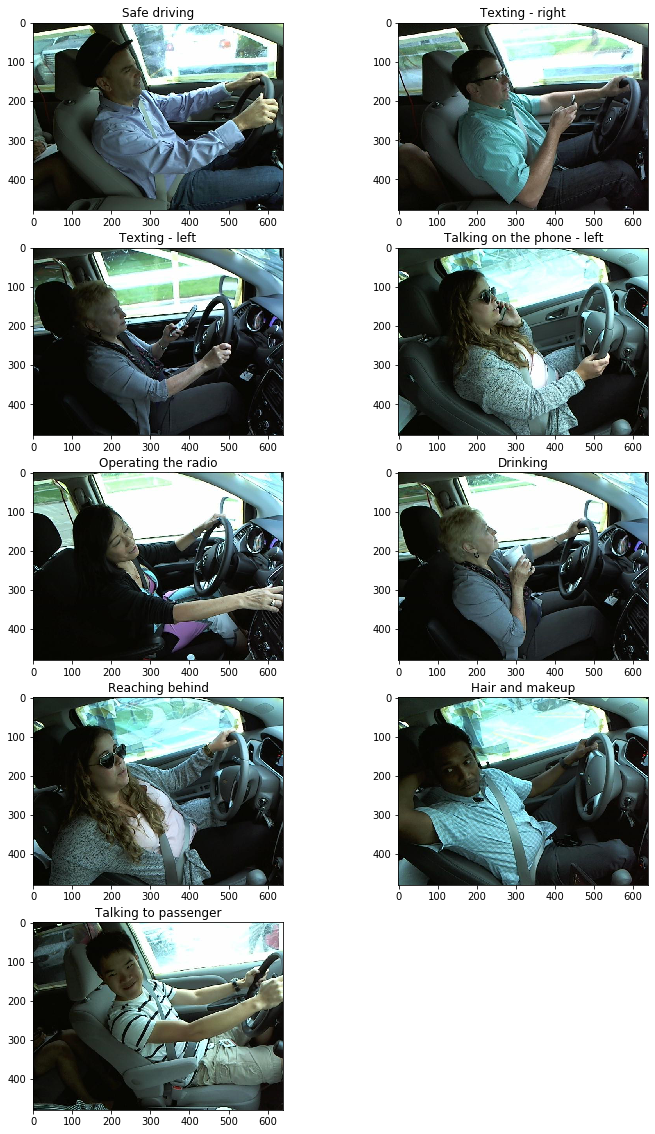

In [0]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/drive/Shared drives/Tensors/DL/drivers/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [0]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

# Create Vanilla Model
**Building the model**

we'll develop the model with a total of 4 Convolutional layers, then a Flatten layer and then 2 Dense layers. we'll use the optimizer as rmsprop, and loss as categorical_crossentropy.

In [0]:
batch_size = 40
nb_epoch = 10

In [0]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [0]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

# Model v1

In [0]:

def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [0]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         


In [0]:

# Training the Vanilla Model version 1
history_v1 = model_v1.fit(nx_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 14400 samples, validate on 3600 samples
Epoch 1/10





14400/14400 [==============================] - 26s 2ms/step - loss: 14.4155 - acc: 0.1050 - val_loss: 14.2735 - val_acc: 0.1144

Epoch 00001: val_loss improved from inf to 14.27347, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10
14400/14400 [==============================] - 16s 1ms/step - loss: 14.4414 - acc: 0.1040 - val_loss: 14.2735 - val_acc: 0.1144

Epoch 00002: val_loss did not improve from 14.27347
Epoch 3/10
14400/14400 [==============================] - 16s 1ms/step - loss: 14.4271 - acc: 0.1049 - val_loss: 14.2735 - val_acc: 0.1144

Epoch 00003: val_loss did not improve from 14.27347
Epoch 00003: early stopping


In [0]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

In [0]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

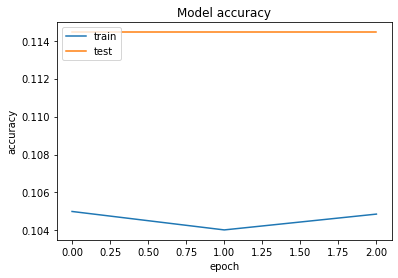

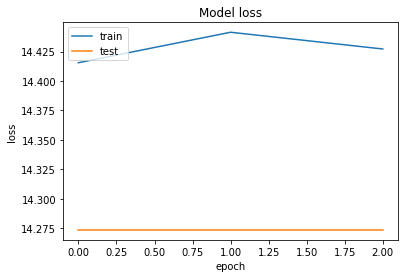

In [0]:
plot_train_history(history_v1)

In [0]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [0]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

3600/3600 [==============================] - 2s 421us/step
Score:  [14.273468822903103, 0.11444444444444445]


1/1 [==============================] - 0s 144ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


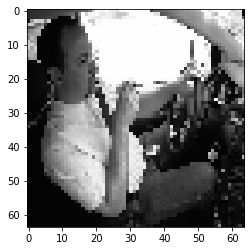

In [0]:
plot_test_class(model_v1, test_files, 20)

#Create a vanilla CNN model with data augmentation
Here I'm augmenting the previous model classifier, I'll use the data on which I want to train the model. The folder train includes the images I need. I'll generate more images using ImageDataGenerator and split the training data into 80% train and 20% validation split.

In [0]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [0]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [0]:
nb_train_samples = nx_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(nx_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

14400
3600


In [0]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_v1.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
360/360 [==============================] - 17s 46ms/step - loss: 1.9016 - acc: 0.2558 - val_loss: 1.1431 - val_acc: 0.6169

Epoch 00001: val_acc improved from -inf to 0.61694, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/5
360/360 [==============================] - 17s 46ms/step - loss: 0.9600 - acc: 0.6585 - val_loss: 0.4221 - val_acc: 0.8708

Epoch 00002: val_acc improved from 0.61694 to 0.87083, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/5
360/360 [==============================] - 17s 47ms/step - loss: 0.5543 - acc: 0.8158 - val_loss: 0.2326 - val_acc: 0.9289

Epoch 00003: val_acc improved from 0.87083 to 0.92889, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 4/5
360/360 [==============================] - 17s 46ms/step - loss: 0.4032 - acc: 0.8720 - val_loss: 0.1665 - val_acc: 0.9528

Epoch 00004: val_acc improved from 0.92889 to 0.95278, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 5/5
360/360 [========

In [0]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

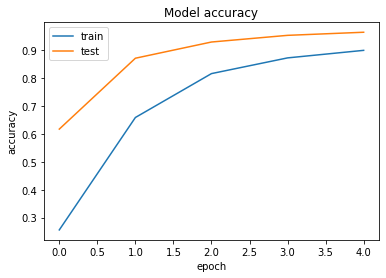

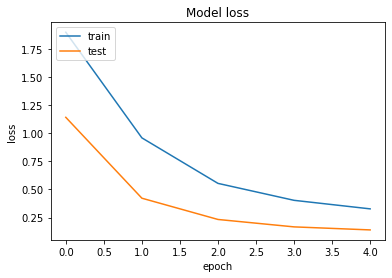

In [0]:
plot_train_history(history_v3)

In [0]:
# Evaluate the performance of the new model
score = model_v1.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.13943608153818382
Test Accuracy: 0.9638888968361748


1/1 [==============================] - 0s 3ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


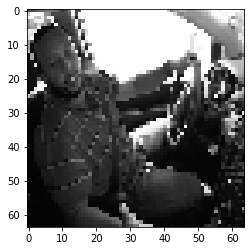

In [0]:
plot_test_class(model_v1, test_files, 101)


Transfer Learning with VGG net

In [0]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model.layers:
        layer.trainable = False
        
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    model = Model(input = vgg16_model.input, output = predictions)
    
    return model

In [0]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________

In [0]:
training_generator = train_datagen.flow_from_directory('/content/drive/Shared drives/Tensors/DL/drivers/train', 
                                                 target_size = (img_rows, img_cols), 
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('/content/drive/Shared drives/Tensors/DL/drivers/train', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

Found 14404 images belonging to 10 classes.
Found 3596 images belonging to 10 classes.


In [0]:
!rm -f saved_models/weights_best_vgg16.hdf5

In [0]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v4 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         class_weight='auto',
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
448/448 [==============================] - 193s 430ms/step - loss: 1.5566 - acc: 0.4249 - val_loss: 1.1058 - val_acc: 0.6177

Epoch 00001: val_acc improved from -inf to 0.61774, saving model to saved_models/weights_best_vgg16.hdf5
Epoch 2/5
448/448 [==============================] - 188s 419ms/step - loss: 1.0912 - acc: 0.6103 - val_loss: 0.9999 - val_acc: 0.6408

Epoch 00002: val_acc improved from 0.61774 to 0.64075, saving model to saved_models/weights_best_vgg16.hdf5
Epoch 3/5
448/448 [==============================] - 189s 423ms/step - loss: 0.8977 - acc: 0.6840 - val_loss: 0.6532 - val_acc: 0.7759

Epoch 00003: val_acc improved from 0.64075 to 0.77592, saving model to saved_models/weights_best_vgg16.hdf5
Epoch 4/5
448/448 [==============================] - 190s 424ms/step - loss: 0.7559 - acc: 0.7392 - val_loss: 0.5574 - val_acc: 0.8128

Epoch 00004: val_acc improved from 0.77592 to 0.81278, saving model to saved_models/weights_best_vgg16.hdf5
Epoch 5/5
448/448 [========

In [0]:
model_vgg16.load_weights('saved_models/weights_best_vgg16.hdf5')

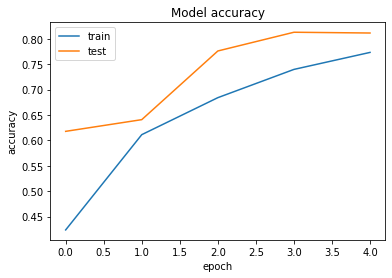

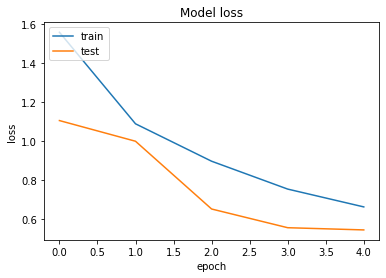

In [0]:
plot_train_history(history_v4)

In [0]:
# Evaluate the performance of the new model
score = model_vgg16.evaluate_generator(validation_generator, nb_validation_samples // batch_size, verbose = 1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

112/112 [==============================] - 34s 302ms/step
Test Score: 0.558316778534752
Test Accuracy: 0.8147899926081633
